# <font color="blue">Project 2: DoppelGanger Find your Celebrity Look-Alike </font>
We have seen how face Recognition algorithms work. In short, they convert a face into a high dimensional vector and then learn a feature space in that high dimension. Once the algorithm learns a robust feature space, you can add more people to the same space and they will form a different cluster.

### <font color="green">Your Task</font>
In this project, we will build a Fun Application - We will use the Face Embeddings to **find a doppelganger or look-alike to a given person.** Specifically, we will give you images of two persons and a celebrity dataset. Your task will be to find their celebrity look-alike. The first person is **Sofia Solares** who looks like the American Singer **Selena Gomez** and the second one is **Shashikant Pedwal** who looks like Indian Film Actor **Amitabh Bachchan**.

Given below is the Expected Output. 

### <font color="green">Expected Output</font>

![](https://www.learnopencv.com/wp-content/uploads/2020/05/doppelganger-output-selena.jpg)

![](https://www.learnopencv.com/wp-content/uploads/2020/05/doppelganger-output-amitabh.jpg)


By now, you should be able to discern what the problem is, and how you are going to solve it. You simply need a dataset which has enough celebrity faces and use face embeddings to match the test image with the celebrity face embeddings. That's enough Hint!

## <font color="blue">The Dataset</font>
There are many datasets which contain images of celebrities. Some of them are:
* [CelebA Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)
* [VGGFace](https://www.robots.ox.ac.uk/~vgg/data/vgg_face/)
* [VGGFace2](http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/)
* [MS-Celeb-1M](https://www.microsoft.com/en-us/research/project/ms-celeb-1m-challenge-recognizing-one-million-celebrities-real-world/)
* [Celebrity-Together Dataset](https://www.robots.ox.ac.uk/~vgg/data/celebrity_together/)

### <font color="green">celeb_mini Dataset</font>
Since most of the datasets are huge in size, we have curated a small dataset for this experiment.

We will use a subset of the Query set of the Celebrity Together Dataset in this project. The query dataset has around 1100 celebs and is ~400MB in size. 

The subset we have created is using 5 images per celebrity and it has been saved in the **`../resource/asnlib/publicdata/celeb_mini`** folder. It is ~70MB in size. We have also provided a **`celeb_mapping.npy`** file which has the mapping of the code name to the actual name of the celebrity.

The **`celeb_mini`** folder has the following structure:

```
celeb_mini
└───n00000001
│   └──n00000001_00000263.JPEG
│   └──n00000001_00000405.JPEG
│      ...
└───n00000003
│   └──n00000003_00000386.JPEG
│   └──n00000003_00000488.JPEG
│       ...
│
```
    
**`celeb_mapping.npy`** contains a dictionary which contains the mapping between the folder names and the celebrity's actual name as show below:
```
{'n00000001': 'A.J. Buckley',
 'n00000002': 'A.R. Rahman',
 'n00000003': 'Aamir Khan',
 'n00000004': 'Aaron Staton',
 'n00000005': 'Aaron Tveit',
 'n00000006': 'Aaron Yoo',
 'n00000007': 'Abbie Cornish',
 .
 .
 .
}
```


## <font color="blue">Marks Distribution </font>
1. **Implementation - 70 Marks**
1. **Video Explanation - 30 marks**

#### <font color="red">Note that you are free to use any other dataset if you have the resources of space and compute to handle the large datasets.</font>


In [1]:
import os,random,glob
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import os.path
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['image.interpolation'] = 'bilinear'

## <font color="blue">Load the model for face landmarks and face recognition</font>

Initialize Dlib’s Face Detector, Facial Landmark Detector and Face Recognition neural network objects

#### <font color="red">You are free to use other face recognition models as well. </font>

In [3]:
# Download dlib models
# Landmark model
!wget https://github.com/davisking/dlib-models/raw/master/shape_predictor_68_face_landmarks.dat.bz2 -O shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2
# Face recognition model
!wget https://github.com/davisking/dlib-models/raw/master/dlib_face_recognition_resnet_model_v1.dat.bz2 -O dlib_face_recognition_resnet_model_v1.dat.bz2
!bzip2 -d dlib_face_recognition_resnet_model_v1.dat.bz2
# Initialize face detector, facial landmarks detector 
# and face recognizer
faceDetector = dlib.get_frontal_face_detector()
# http://dlib.net/python/index.html#dlib_pybind11.shape_predictor
shapePredictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
faceRecognizer = dlib.face_recognition_model_v1('dlib_face_recognition_resnet_model_v1.dat')

--2023-11-19 18:41:39--  https://github.com/davisking/dlib-models/raw/master/shape_predictor_68_face_landmarks.dat.bz2
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/davisking/dlib-models/master/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2023-11-19 18:41:39--  https://raw.githubusercontent.com/davisking/dlib-models/master/shape_predictor_68_face_landmarks.dat.bz2
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M) [application/octet-stream]
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M   142MB/s    in 0

## <font color="blue">Explore Data </font>
In this section, we provide sample code of how to load the images and use the label mapping for your reference. This should help you get started with handling images and finding the embeddings.

In [5]:
!wget https://www.dropbox.com/s/lulw2jwsblz687g/celeb_mini.zip?dl=1 -O celeb_mini.zip
!unzip celeb_mini.zip

!wget https://www.dropbox.com/s/m7kjjoa1z1hsxw6/celeb_mapping.npy?dl=1 -O celeb_mapping.npy

!wget https://www.dropbox.com/s/3yi89blp4lhiw6y/test-images.zip?dl=1 -O test-images.zip
!unzip test-images.zip

--2023-11-19 18:41:42--  https://www.dropbox.com/s/lulw2jwsblz687g/celeb_mini.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/lulw2jwsblz687g/celeb_mini.zip [following]
--2023-11-19 18:41:42--  https://www.dropbox.com/s/dl/lulw2jwsblz687g/celeb_mini.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca809636de98e72634bbe397a7d.dl.dropboxusercontent.com/cd/0/get/CH3GtMTDmEy1ye0o3jR9gKEDr9mKfQXBdtgM85FatikFiP0c8wCSp_KiPnR5eehFG6q3f5LvFgqaYnRYtk4Os4yhe2M2kITPdklLOTAQ4ABS8Z-LipQdkw8oI8ycgpRZr4MIrRqiQeaZ4Jaux8NTg-vn/file?dl=1# [following]
--2023-11-19 18:41:42--  https://uca809636de98e72634bbe397a7d.dl.dropboxusercontent.com/cd/0/get/CH3GtMTDmEy1ye0o3jR9gKEDr9mKfQXBdtgM85FatikFiP0c8wCSp_KiPnR5eehFG6q3f5LvFgqaYnRYtk4Os4yhe2M2kI

In [4]:
# Root folder of the dataset
faceDatasetFolder = 'celeb_mini'
# Label -> Name Mapping file
labelMap = np.load("celeb_mapping.npy", allow_pickle=True).item()

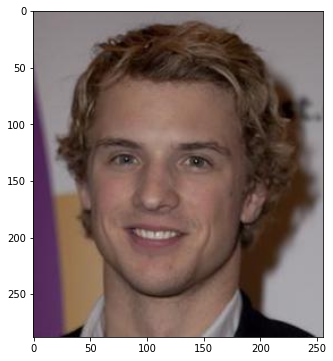

File path = celeb_mini/n00000729/n00000729_00000016.JPEG
Celeb Name: Freddie Stroma


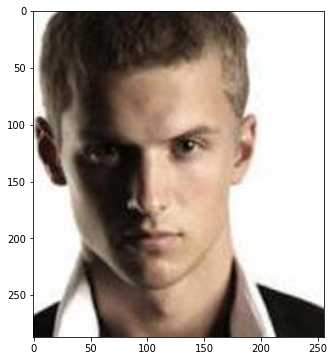

File path = celeb_mini/n00000729/n00000729_00000313.JPEG
Celeb Name: Freddie Stroma


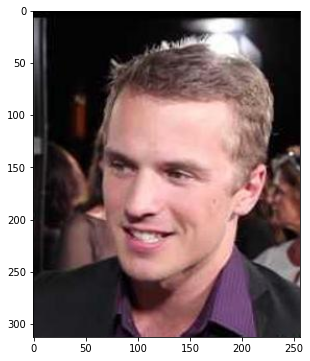

File path = celeb_mini/n00000729/n00000729_00000738.JPEG
Celeb Name: Freddie Stroma


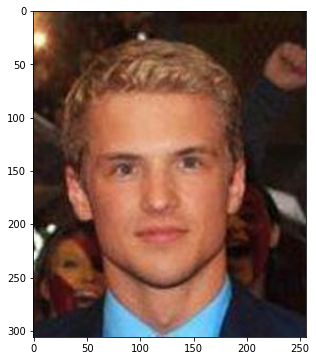

File path = celeb_mini/n00000729/n00000729_00000082.JPEG
Celeb Name: Freddie Stroma


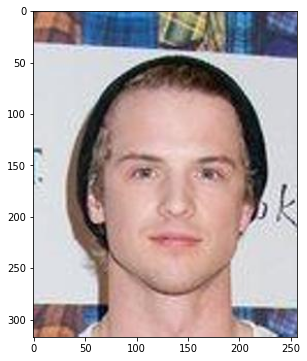

File path = celeb_mini/n00000729/n00000729_00000057.JPEG
Celeb Name: Freddie Stroma


In [6]:
# Each subfolder has images of a particular celeb
subfolders = os.listdir(faceDatasetFolder)

# Let us choose a random folder and display all images
random_folder = random.choice(subfolders)

# Also find out the name of the celeb from the folder name and folder-> name mapping dictionary loaded earlier
celebname = labelMap[random_folder]

# Load all images in the subfolder
imagefiles = os.listdir(os.path.join(faceDatasetFolder, random_folder))

# Read each image and display along with the filename and celeb name
for file in imagefiles:
#     Get full path of each image file
    fullPath = os.path.join(faceDatasetFolder,random_folder,file)
    im = cv2.imread(fullPath)
    plt.imshow(im[:,:,::-1])
    plt.show()
#     Also print the filename and celeb name
    print("File path = {}".format(fullPath))
    print("Celeb Name: {}".format(celebname))

## <font color="blue">TODO</font>
You have to write the code for enrollment and testing to get the desired output as shown in the intro section.

**You can take help from the code we had provided in week 4 material.**

## <font color="red">1. Enrollment of Celeb Images </font>
Process images one by and one. 

Convert image from RGB to BGR, because Dlib uses RGB as default format.

Detect faces in the image and compute a face descriptor for each image and save them in an array so that it can be used during testing.

In [7]:
#####################
# Create an empty list to store face descriptors and corresponding celeb names
enrolledCelebs = []

# Process each subfolder (celeb) in the dataset
for celeb_folder in subfolders:
    celeb_name = labelMap[celeb_folder]
    
    # Load all images in the celeb subfolder
    celeb_image_files = os.listdir(os.path.join(faceDatasetFolder, celeb_folder))
    
    # Initialize an empty list to store face descriptors for the current celeb
    celeb_descriptors = []
    
    # Process each image in the celeb subfolder
    for file in celeb_image_files:
        # Get the full path of each image file
        full_path = os.path.join(faceDatasetFolder, celeb_folder, file)
        
        # Read the image
        img = cv2.imread(full_path)
        
        # Convert image to RGB (Dlib uses RGB)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Detect faces in the image
        faces = faceDetector(img_rgb)
        
        # Assuming there is only one face in each image for simplicity
        if len(faces) == 1:
            # Compute face descriptor
                # shapePredictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
                # http://dlib.net/python/index.html#dlib_pybind11.shape_predictor
                # This object is a tool that takes in an image region containing some object 
                # and outputs a set of point locations that define the pose of the object.
            landmarks = shapePredictor(img_rgb, faces[0])
                # faceRecognizer = dlib.face_recognition_model_v1('dlib_face_recognition_resnet_model_v1.dat')
                # http://dlib.net/python/index.html#dlib_pybind11.face_recognition_model_v1
                # This object maps human faces into 128D vectors,
                # where pictures of the same person are mapped near to each other,
                # and pictures of different people are mapped far apart.
            face_descriptor = faceRecognizer.compute_face_descriptor(img_rgb, landmarks)
            
            # Append face descriptor and celeb name to the list
            celeb_descriptors.append((face_descriptor, celeb_name))
    
    # Append celeb descriptors to the overall list
    enrolledCelebs.extend(celeb_descriptors)

# Save the enrolled celebs to a file for later use
np.save("enrolled_celebs.npy", enrolledCelebs)
#####################

/usr/local/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


## <font color="red">2. Testing</font>
Once you have enrolled the celebs, you should be able to use them to find the closest celeb to the given test image using minimum distance rule.

You need to find the embeddings of the test images and compare it with the enrolled celebs to find the look-alike. 

Finally, display the celeb along side the input image. Partial code is given.

In [10]:
matplotlib.rcParams['figure.figsize'] = (12.0,12.0)

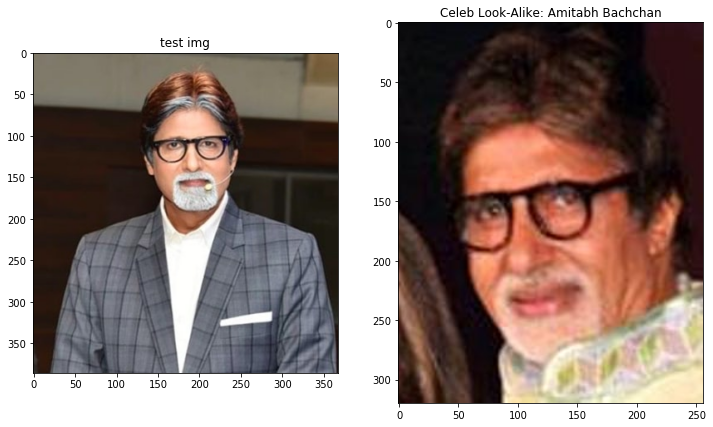

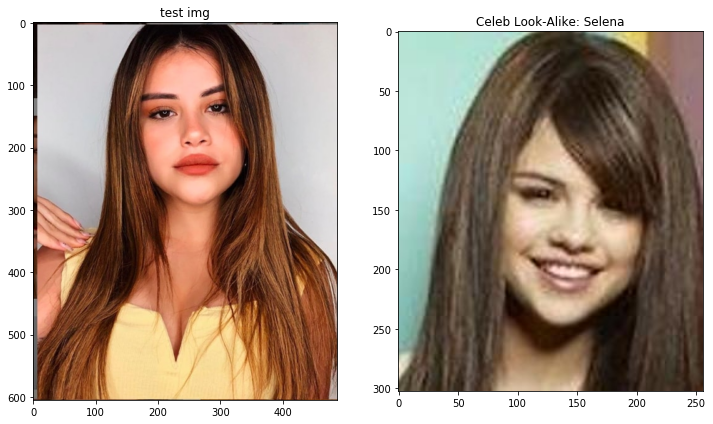

In [12]:
# read image
testImages = glob.glob('test-images/*.jpg')

for test in testImages:
    im = cv2.imread(test)
    imDlib = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    
    #####################
    # Detect faces in the test image
    # faceDetector = dlib.get_frontal_face_detector()
    # http://dlib.net/python/index.html#dlib_pybind11.get_frontal_face_detector
    # Returns the default face detector
    faces = faceDetector(imDlib)
    
    # Assuming there is only one face in each test image for simplicity
    if len(faces) == 1:
        # Compute face descriptor for the test image
        landmarks = shapePredictor(imDlib, faces[0])
        test_descriptor = faceRecognizer.compute_face_descriptor(imDlib, landmarks)
        
        # Find the closest celeb using minimum distance rule
        min_distance = float('inf')
        celeb_name = ""
        
        for celeb_descriptor, celeb_name_enrolled in enrolledCelebs:
            distance = np.linalg.norm(np.array(test_descriptor) - np.array(celeb_descriptor))
            
            # Update closest celeb if a smaller distance is found
            if distance < min_distance:
                min_distance = distance
                celeb_name = celeb_name_enrolled
    ####################
    
    plt.subplot(121)
    plt.imshow(imDlib)
    plt.title("test img")
    
    #display celeb image which looks like the test image instead of the black image. 
    plt.subplot(122)
    #####################
    # Load and display the look-alike celeb image
    look_alike_path = os.path.join(faceDatasetFolder, [folder for folder, name in labelMap.items() if name == celeb_name][0])
    look_alike_path = os.path.join(look_alike_path, os.listdir(look_alike_path)[0])
    look_alike_img = cv2.imread(look_alike_path)
    plt.imshow(cv2.cvtColor(look_alike_img, cv2.COLOR_BGR2RGB))
    #####################
    plt.title("Celeb Look-Alike: {}".format(celeb_name))
    plt.show()